# Forecasting one step ahead

In the previous notebook, we lined up the feature engineering steps into a Scikit-learn pipeline and then created all the features with one line of code.

In this notebook, we'll examine how to use a train-test split strategy to forecast pollutant concentrations for the next hour.

We'll split the data into train and test sets, then train the feature engineering stages and Lasso regression on the train set before evaluating the results on the test set.

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# Same function we saw in section 2.

def load_data():

    # Data lives here.
    filename = "../Datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor", "RH"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

In [3]:
# Load data.

data = load_data()

data.head()

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,1224.0,56.5
2004-04-04 01:00:00,1215.0,59.2
2004-04-04 02:00:00,1115.0,62.4
2004-04-04 03:00:00,1124.0,65.0
2004-04-04 04:00:00,1028.0,65.3


# Feature engineering steps

The same pipeline from the previous notebook.

In [4]:
# Datetime features

dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [5]:
# Lag features.

lagf = LagFeatures(
    variables=["CO_sensor", "RH"],  # the input variables
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [6]:
# Window features

winf = WindowFeatures(
    variables=["CO_sensor", "RH"],  # the input variables
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [7]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [8]:
# Drop missing data
imputer = DropMissingData()

In [9]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["CO_sensor", "RH"])

# Feature engineering pipeline

In [10]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

# Split data into train and test

We will evaluate the performance of the model in a test set consisting of the last month of data.

In [11]:
# Check data span:

data.index.min(), data.index.max()

(Timestamp('2004-04-04 00:00:00'), Timestamp('2005-04-04 14:00:00'))

Due to our 24h lag feature, we need data about the pollutant information at least 24 hours before the first forecasting point in the test set to create input features.

Thus, the test set must contain the first forecasting point plus the previous 24 hours.

In [13]:
# The last month of data begins on 2005-03-4.

# But we need 24 hr of prior data to create
# the necessary features:

pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)

Timestamp('2005-03-03 00:00:00')

In [14]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2005-03-04"]["CO_sensor"]
y_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)][
    "CO_sensor"
]

In [18]:
# Let's check that we have the correct data span
# in the test set:

X_test.index.min(), X_test.index.max()

(Timestamp('2005-03-03 00:00:00'), Timestamp('2005-04-04 14:00:00'))

# Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [16]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,
2004-04-05 00:00:00,4,15,0,5,0,0,1188.0,60.8,1224.0,56.5,1165.666667,58.566667,0.866025,-0.5,0.000000,1.000000
2004-04-05 01:00:00,4,15,0,5,1,0,1065.0,65.8,1215.0,59.2,1149.666667,61.800000,0.866025,-0.5,0.269797,0.962917
2004-04-05 02:00:00,4,15,0,5,2,0,999.0,79.2,1115.0,62.4,1084.000000,68.600000,0.866025,-0.5,0.519584,0.854419
2004-04-05 03:00:00,4,15,0,5,3,0,911.0,80.0,1124.0,65.0,991.666667,75.000000,0.866025,-0.5,0.730836,0.682553
2004-04-05 04:00:00,4,15,0,5,4,0,873.0,81.0,1028.0,65.3,927.666667,80.066667,0.866025,-0.5,0.887885,0.460065


In [17]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(6850,)
(6427,)


In [19]:
# Lasso regression

lasso = Lasso(random_state=0)

# Train the model

lasso.fit(X_train_t, y_train_t)

Lasso(random_state=0)

In [20]:
# Make predictions

preds = lasso.predict(X_train_t)

preds

array([1153.64837067, 1033.54156603,  985.74093314, ..., 1343.3048774 ,
       1243.24684182, 1168.50421853])

Text(0.5, 1.0, 'Forecast: train set')

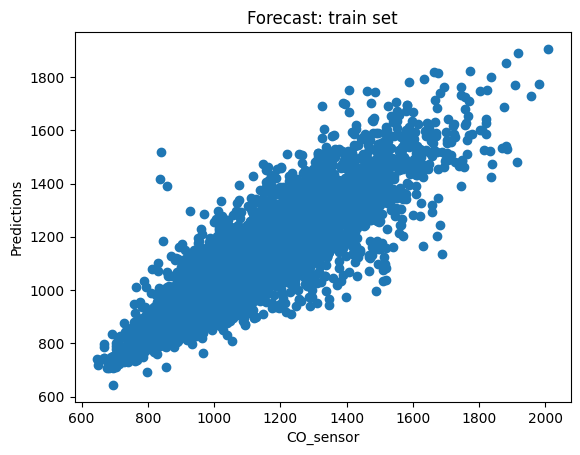

In [21]:
# Plot the predictions vs the truth.

plt.scatter(y_train_t, preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast: train set")

In [22]:
# The RMSE in the train set.

mean_squared_error(preds, y_train_t, squared=False)

92.21694976514135

On the train set, the model seems to be doing a decent job.

# Evaluate model

We will evaluate the performance of the model in our test set now.

In [23]:
# Create the input features:

X_test_t = pipe.transform(X_test)

X_test_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,RH_lag_1H,CO_sensor_lag_24H,RH_lag_24H,CO_sensor_window_3H_mean,RH_window_3H_mean,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,,,,,,,,,,,,,
2005-03-04 00:00:00,3,9,4,4,0,0,1179.0,82.0,1047.0,41.7,1223.333333,82.700000,1.0,6.123234e-17,0.000000,1.000000
2005-03-04 01:00:00,3,9,4,4,1,0,929.0,37.4,1030.0,43.3,1104.666667,67.300000,1.0,6.123234e-17,0.269797,0.962917
2005-03-04 02:00:00,3,9,4,4,2,0,951.0,40.8,986.0,45.9,1019.666667,53.400000,1.0,6.123234e-17,0.519584,0.854419
2005-03-04 03:00:00,3,9,4,4,3,0,938.0,44.2,992.0,49.7,939.333333,40.800000,1.0,6.123234e-17,0.730836,0.682553
2005-03-04 04:00:00,3,9,4,4,4,0,921.0,48.7,1076.0,56.3,936.666667,44.566667,1.0,6.123234e-17,0.887885,0.460065


In [24]:
# Note that the prior 24 hr of information
# dissapeared from our test set (they had null data).

# Our dataset contains the first forecasting point
# as expected.

X_test_t.index.min(), X_test_t.index.max()

(Timestamp('2005-03-04 00:00:00'), Timestamp('2005-04-04 14:00:00'))

In [25]:
# Make predictions.

preds = lasso.predict(X_test_t)

preds[0:10]

array([1122.2269227 ,  855.95634311,  910.00549256,  931.51941646,
        929.00244686,  868.51544281,  849.8519462 ,  907.782453  ,
        972.14913519, 1006.27472793])

In [26]:
print(y_test.shape)

# Adjust the target, it has observations
# that were removed from the test set due
# to null values.

y_test_t = y_test.loc[X_test_t.index]

print(y_test_t.shape)

(567,)
(495,)


Text(0.5, 1.0, 'Forecast: test set')

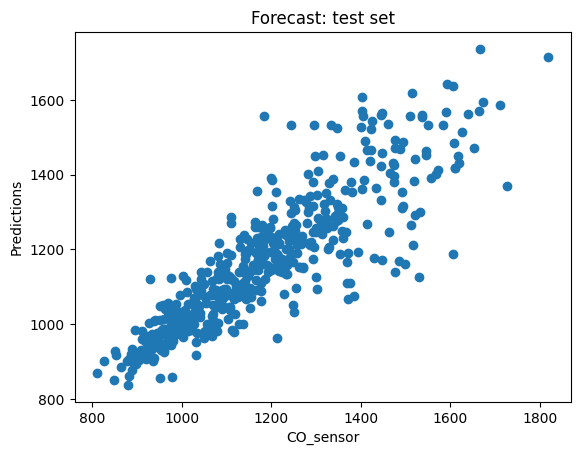

In [27]:
# Plot the predictions vs the truth.

plt.scatter(y_test_t, preds)
plt.xlabel("CO_sensor")
plt.ylabel("Predictions")
plt.title("Forecast: test set")

In [28]:
# RMSE in test set

mean_squared_error(preds, y_test_t, squared=False)

95.4141631246702

We see that our linear regression makes fairly good predictions of the pollutant concentration in the next hour.